### **Load all required libraries**

In [1]:
!pip install transformers --quiet
!pip install opendatasets --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### **Load the Sarcasm Dataset**

In [3]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/sarcasm.json', lines=True)

In [4]:
# view the first 5 rows of the dataframe
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
# print the shape of the dataframe
df.shape

(26709, 3)

In [6]:
# check for any null values
df.isnull().sum()

,0
article_link,0
headline,0
is_sarcastic,0


### **Data Cleaning**🧼🧽

In [7]:
# check for duplicates
df.duplicated().sum()

# drop the duplicates
df.drop_duplicates(inplace=True)

# confirm above changes
df.shape

(26708, 3)

In [8]:
# drop the 'article_link' column
df.drop('article_link', inplace=True, axis=1)

# confirm above changes
df.shape

(26708, 2)

In [9]:
# view first 5 rows of the dataframe after all the above changes
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

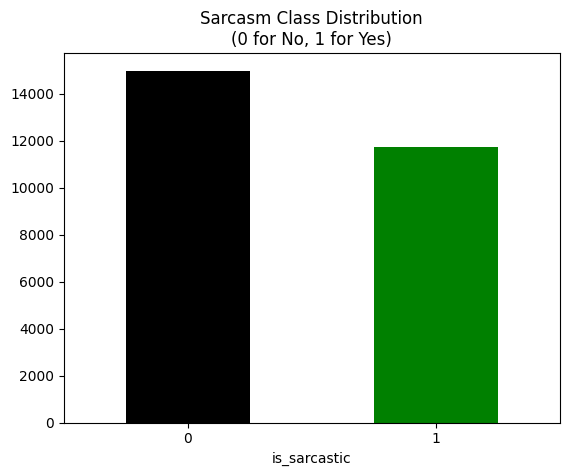

In [10]:
# check for class balance distribution
df['is_sarcastic'].value_counts().plot(kind='bar', color=['black', 'green'])
plt.title('Sarcasm Class Distribution\n(0 for No, 1 for Yes)')
plt.xticks(rotation=0)

### **Data Preprocessing, Model Selection and Evaluation**🧹🎯📊

In [11]:
# assign the X and y variables
X = df['headline'].values # convert to numpy array
y = df['is_sarcastic'].values # convert to numpy array

In [12]:
# split the dataset for training, validation and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

# check above changes
print(f'Training Set: {X_train.shape}')
print(f'Validation Set: {X_val.shape}')
print(f'Testing Set: {X_test.shape}')

Training Set: (18695,)
Validation Set: (4006,)
Testing Set: (4007,)


In [13]:
# Load model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
class dataset(Dataset):
  def __init__(self, X, y):
    self.X = [tokenizer(x, max_length=100, truncation=True, padding='max_length', return_tensors = 'pt') for x in X]
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [15]:
batch_size = 32

training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

In [16]:
# building the model
class Model(nn.Module):
  def __init__(self, bert):
    super(Model, self).__init__()

    self.bert = bert
    self.dropout = nn.Dropout(0.25)
    self.linear1 = nn.Linear(768, 384)
    self.linear2 = nn.Linear(384, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(input_ids, attention_mask, return_dict=False)[0][:,0]
    output = self.linear1(pooled_output)
    output = self.dropout(output)
    output = self.linear2(output)
    output = self.sigmoid(output)
    return output

In [17]:
for param in bert_model.parameters():
  param.requires_grad = False

model = Model(bert_model)
model

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [18]:
epochs = 10
learning_rate = 0.0001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(epochs):
  total_loss_train = 0
  total_loss_validation = 0
  total_acc_train = 0
  total_acc_validation = 0

  for index, data in enumerate(training_dataloader):
    inputs, labels = data

    prediction = model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()

    acc = (prediction.round() == labels).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for index, data in enumerate(validation_dataloader):
      inputs, labels = data

      prediction = model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_validation += batch_loss.item()

      acc = (prediction.round() == labels).sum().item()
      total_acc_validation += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_validation/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__() * 100, 4))

  print(f"""
          Epoch No: {epoch+1} | Train Loss: {round(total_loss_train/1000, 4)} | Train Accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)} | Validation Loss: {round(total_loss_validation/1000, 4)} | Validation Accuracy: {round(total_acc_validation/validation_data.__len__() * 100, 4)}
        """)



          Epoch No: 1 | Train Loss: 0.2633 | Train Accuracy: 79.9091 | Validation Loss: 0.0477 | Validation Accuracy: 83.7244
        

          Epoch No: 2 | Train Loss: 0.2138 | Train Accuracy: 84.2846 | Validation Loss: 0.0447 | Validation Accuracy: 84.3984
        

          Epoch No: 3 | Train Loss: 0.2006 | Train Accuracy: 85.3062 | Validation Loss: 0.0433 | Validation Accuracy: 85.0974
        

          Epoch No: 4 | Train Loss: 0.1934 | Train Accuracy: 85.8732 | Validation Loss: 0.0426 | Validation Accuracy: 85.2721
        

          Epoch No: 5 | Train Loss: 0.1889 | Train Accuracy: 86.1942 | Validation Loss: 0.0417 | Validation Accuracy: 85.4219
        

          Epoch No: 6 | Train Loss: 0.1846 | Train Accuracy: 86.6649 | Validation Loss: 0.0422 | Validation Accuracy: 85.5966
        

          Epoch No: 7 | Train Loss: 0.183 | Train Accuracy: 86.5312 | Validation Loss: 0.0406 | Validation Accuracy: 86.0459
        

          Epoch No: 8 | Train Loss: 0.1824 | Tra

In [20]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

for index, data in enumerate(testing_dataloader):
  inputs, labels = data

  prediction = model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
  batch_loss = criterion(prediction, labels)
  total_loss_test += batch_loss.item()

  acc = (prediction.round() == labels).sum().item()
  total_acc_test += acc

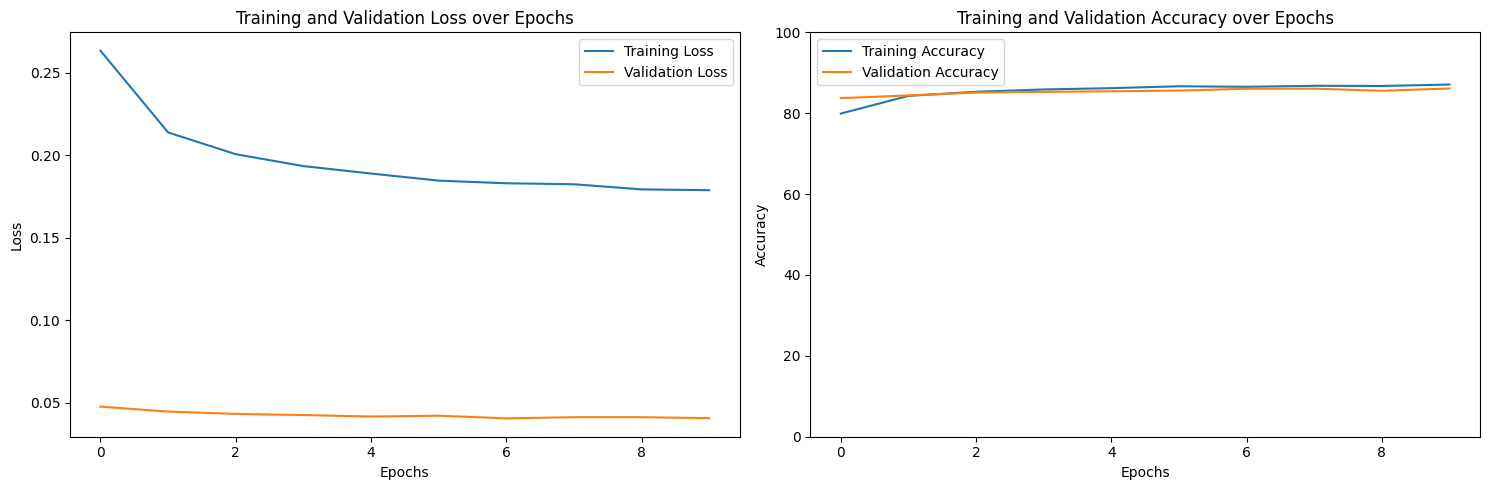

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 0.30])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()